# This notebook will be mainly used for the capstone project.

In [1]:
!pip install folium

     |████████████████████████████████| 102kB 10.5MB/s ta 0:00:01


## Import Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium.plugins import MiniMap
import matplotlib.pyplot as plt

## Load neighborhoods in New York and Toronto

### Download New York Data

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


### Let's take a look at the relevant data in a pandas dataframe

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
print("{} neighborhoods found in New York city.".format(neighborhoods_ny.shape[0]))

40 neighborhoods found in New York city.


### Download Toronto Data

In [8]:
#scraping wikipedia data
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

### Let's take a look at the relevant data in a pandas dataframe

In [9]:
#dropping rows wich has "Not assigned"
df=df[df.Borough != 'Not assigned']
#replacing "/" to ","
df['Neighborhood'] = df['Neighborhood'].str.replace(' /',',')
df=df.reset_index(drop=True)

In [10]:
df = df.replace('Not assigned',np.nan, regex=True)
df.dropna(subset=["Borough"], axis=0, inplace=True)
df = df.reset_index(drop=True)

In [11]:
url = "http://cocl.us/Geospatial_data"
df2 = pd.read_csv(url)

neighborhoods_to=df.merge(df2, how="inner" ,on="Postal Code")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)
neighborhoods_to.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [12]:
print("\n{} neighborhoods found in the city of Toronto.".format(neighborhoods_to.shape[0]))


39 neighborhoods found in the city of Toronto.


## Visualize the neighborhoods in New York and Toronto

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7896239, -73.9598939.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.

The geograpical central coordinates are 42.2215528, -76.6719143.


In [14]:

tmp = neighborhoods_to.drop("Postal Code",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
78,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


In [15]:
map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

In [16]:
map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

In [17]:
map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

## Import data from Foursquare

In [18]:
CLIENT_ID = 'QYXDDMHXZ0CHZPIJLF1T4T145IIFSOEWBN13RYC1Z4SL2YG2' # your Foursquare ID
CLIENT_SECRET = 'DPLTEXTFEHOL2Z2KEQL23TP200NSOQTVM0YYLBSEDWNK3XZV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [19]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)

In [20]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Regent Park, Harbourfront
42 | Queen's Park, Ontario Provincial Government
43 | Garden District, Ryerson
44 | St. James Town
45 | The Beaches
46 | Berczy Park
47 | Central Bay Street
48 | Christie
49 | Richmond, Adelaide, King
50 | Dufferin, Dovercourt Village
51 | Harbourfront East, Uni

In [21]:
# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pe

## Clustering

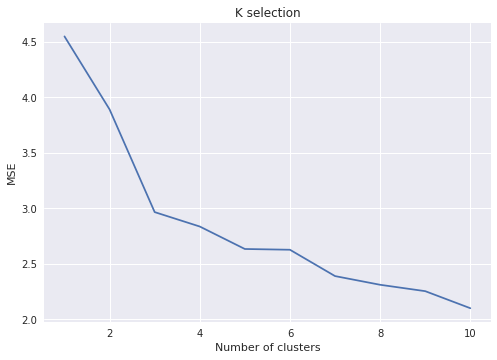

In [22]:

# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [23]:
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
78,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


In [30]:

# set number of clusters
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,5
1,Manhattan,Chinatown,40.715618,-73.994279,5
2,Manhattan,Washington Heights,40.851903,-73.936900,4
...,...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,5
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,5
78,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,5


## Display clusters in a map

In [27]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [31]:
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

##  Analyze Centroids

In [32]:
cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

,Neighborhood
56,"Commerce Court, Victoria Hotel"


In [34]:
cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

,Neighborhood
23,Soho
67,"University of Toronto, Harbord"


In [36]:
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

,Neighborhood
64,"The Annex, North Midtown, Yorkville"


In [37]:
cl4 = tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl4

,Neighborhood
16,Murray Hill
45,Berczy Park


In [38]:
cl5 = tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl5

,Neighborhood
2,Washington Heights
6,Central Harlem
14,Clinton
...,...
53,"Toronto Dominion Centre, Design Exchange"
61,"Forest Hill North & West, Forest Hill Road Park"
69,"Moore Park, Summerhill East"


In [39]:
cl6 = tony_merged.loc[tony_merged['Cluster Labels'] == 6, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl6

,Neighborhood
34,Sutton Place
55,"India Bazaar, The Beaches West"


In [40]:
cl7 = tony_merged.loc[tony_merged['Cluster Labels'] == 7, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl7

,Neighborhood


## Bar Chart for Clusters

In [44]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[2,:]
tmp[5,:] = kmeans.cluster_centers_[5,:]
tmp[6,:] = kmeans.cluster_centers_[6,:]
maxi = []
for i in range(7):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V','Cluster VI','Cluster VII'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

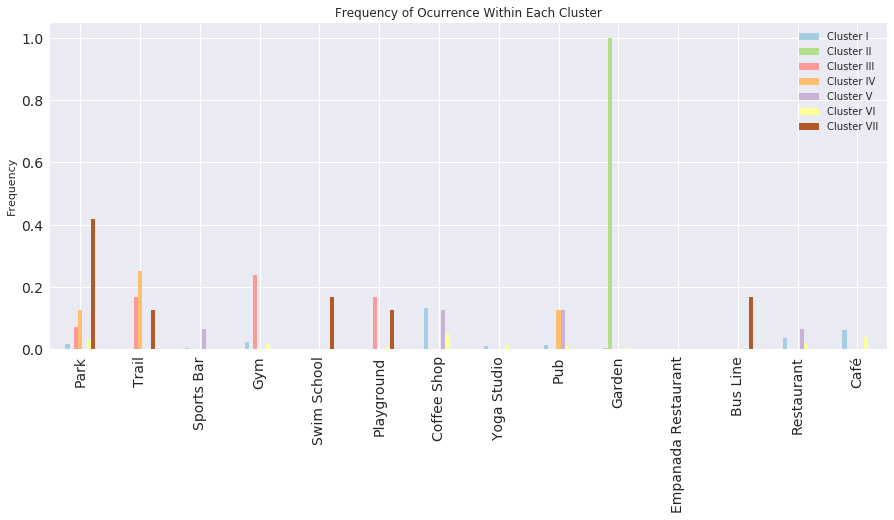

In [45]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [ ]:
maxi = []
for i in range(7):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.T
table.drop(["Garden"], inplace= True)